## Investigation on the effect of numerical formats on MACE-MP

The current iteration of the MACE-MP foundation model use float64 for storing the master weights.
This is motivated by the prior observation that using float32 would corrupt the resulting 
potential energy surface into a piecewise flat and noisy curve.  See Fig 7 of 
[The Design Space of E(3)-Equivariant Atom-Centered Interatomic Potentials](http://arxiv.org/abs/2205.06643)

In [1]:
import torch
import ase.io
import ase.data
import numpy as np
import pandas as pd
from mace.calculators import mace_mp
from mace.tools.torch_tools import default_dtype
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

/opt/conda/envs/mace/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Use the 3BPA benchmark dataset available here:
https://github.com/davkovacs/BOTNet-datasets/tree/main/dataset_3BPA

In [2]:
file = "/data/BOTNet-datasets/dataset_3BPA/test_dih.xyz"
dataset = ase.io.read(file, index=":")
len(dataset)

7047

In [3]:
def potential_energy(dataset, dtype, device, **kwargs):
    dtype_str = str(dtype).split(".")[-1]

    with default_dtype(dtype):
        mace_calc = mace_mp(default_dtype=dtype_str, device=device, **kwargs)

        for d in dataset:
            d.calc = mace_calc

        E = np.array([d.get_potential_energy() for d in dataset])
        F = [d.get_forces() for d in dataset]
        df = pd.DataFrame({"Energy (eV)": E, "Force (eV / A)": F})
        df.label = f"{dtype_str} {device}"
        return df


def compare(A, B):
    assert len(A.columns) == len(B.columns)

    nvars = len(A.columns)
    fig, axes = plt.subplots(nvars, 2, figsize=(12, 6 * nvars))

    for ax, var in zip(axes, A.columns):
        a = np.stack(A[var]).reshape(-1)
        b = np.stack(B[var]).reshape(-1)

        data = pd.DataFrame({A.label: a, B.label: b})
        sns.regplot(ax=ax[0], data=data, x=A.label, y=B.label, line_kws={"color": "r"})
        rmse = np.sqrt(np.mean((a - b) ** 2))
        ax[0].title.set_text(f"{var} RMSE: {rmse:0.3e}")

        abse = np.abs(a - b)
        sns.histplot(data=abse, stat="proportion", ax=ax[1])
        ax[1].title.set_text(f"{var} MAE {np.mean(abse):0.3e}")
        ax[1].set_xlabel(f"|{A.label} - {B.label}|")

    fig.tight_layout()

In [4]:
fp64_cuda = potential_energy(dataset, torch.float64, device="cuda")

Using local medium Materials Project MACE model for MACECalculator /home/ubuntu/macehh/mace/calculators/foundations_models/2023-12-03-mace-mp.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/opt/conda/envs/mace/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/opt/conda/envs/mace/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/opt/conda/envs/mace/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/opt/conda/envs/mace/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [5]:
fp32_cuda = potential_energy(dataset, torch.float32, device="cuda")

Using local medium Materials Project MACE model for MACECalculator /home/ubuntu/macehh/mace/calculators/foundations_models/2023-12-03-mace-mp.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


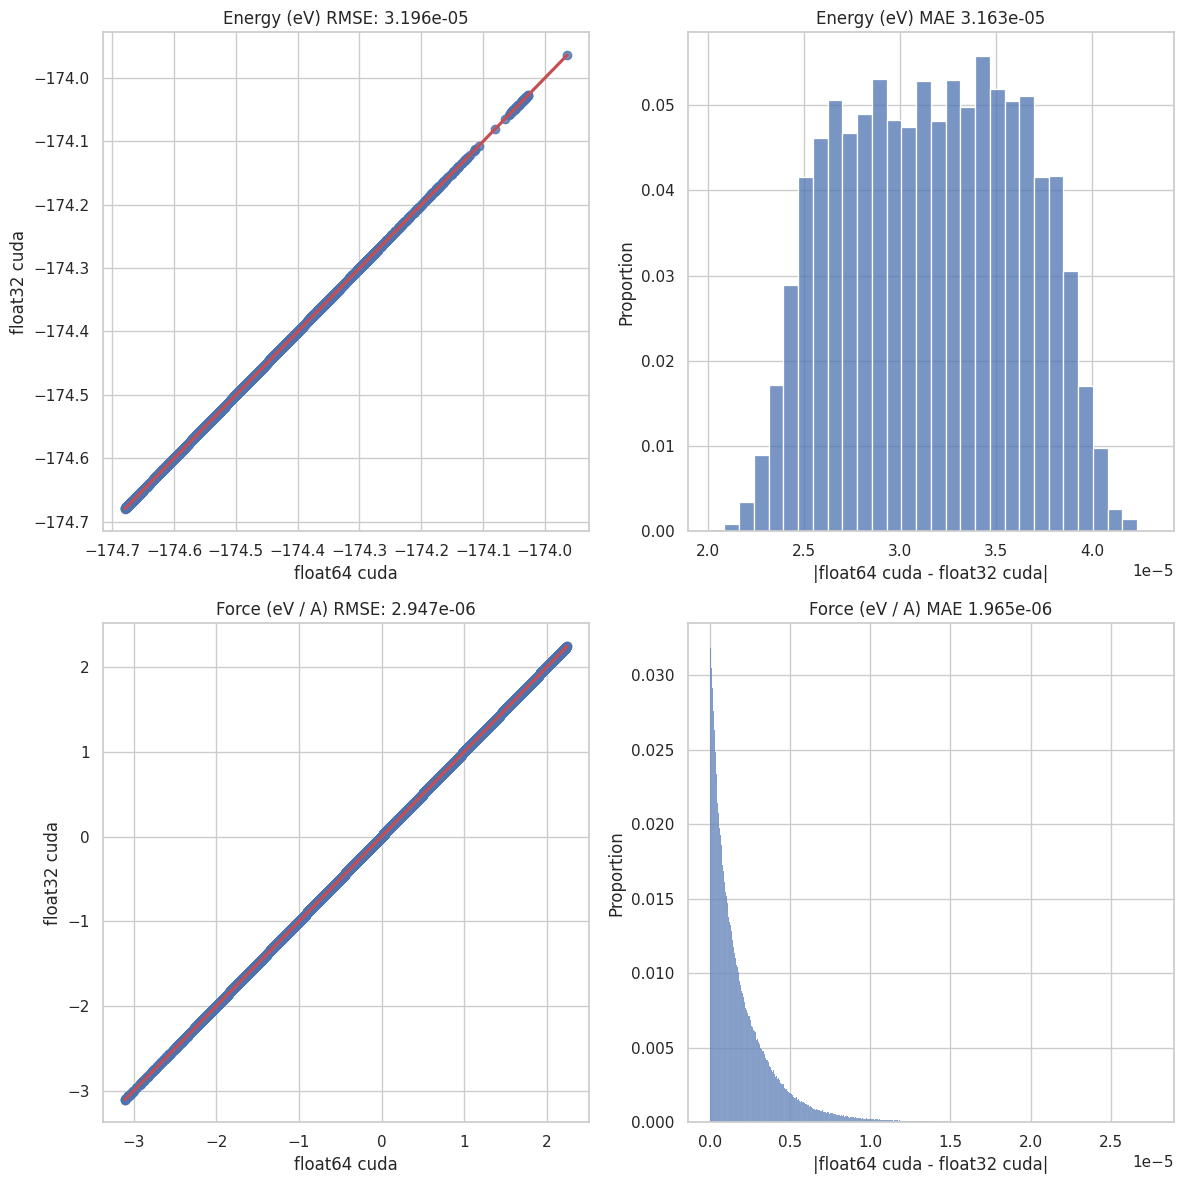

In [6]:
compare(fp64_cuda, fp32_cuda)

In [7]:
fp64_cpu = potential_energy(dataset, torch.float64, device="cpu")

Using local medium Materials Project MACE model for MACECalculator /home/ubuntu/macehh/mace/calculators/foundations_models/2023-12-03-mace-mp.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


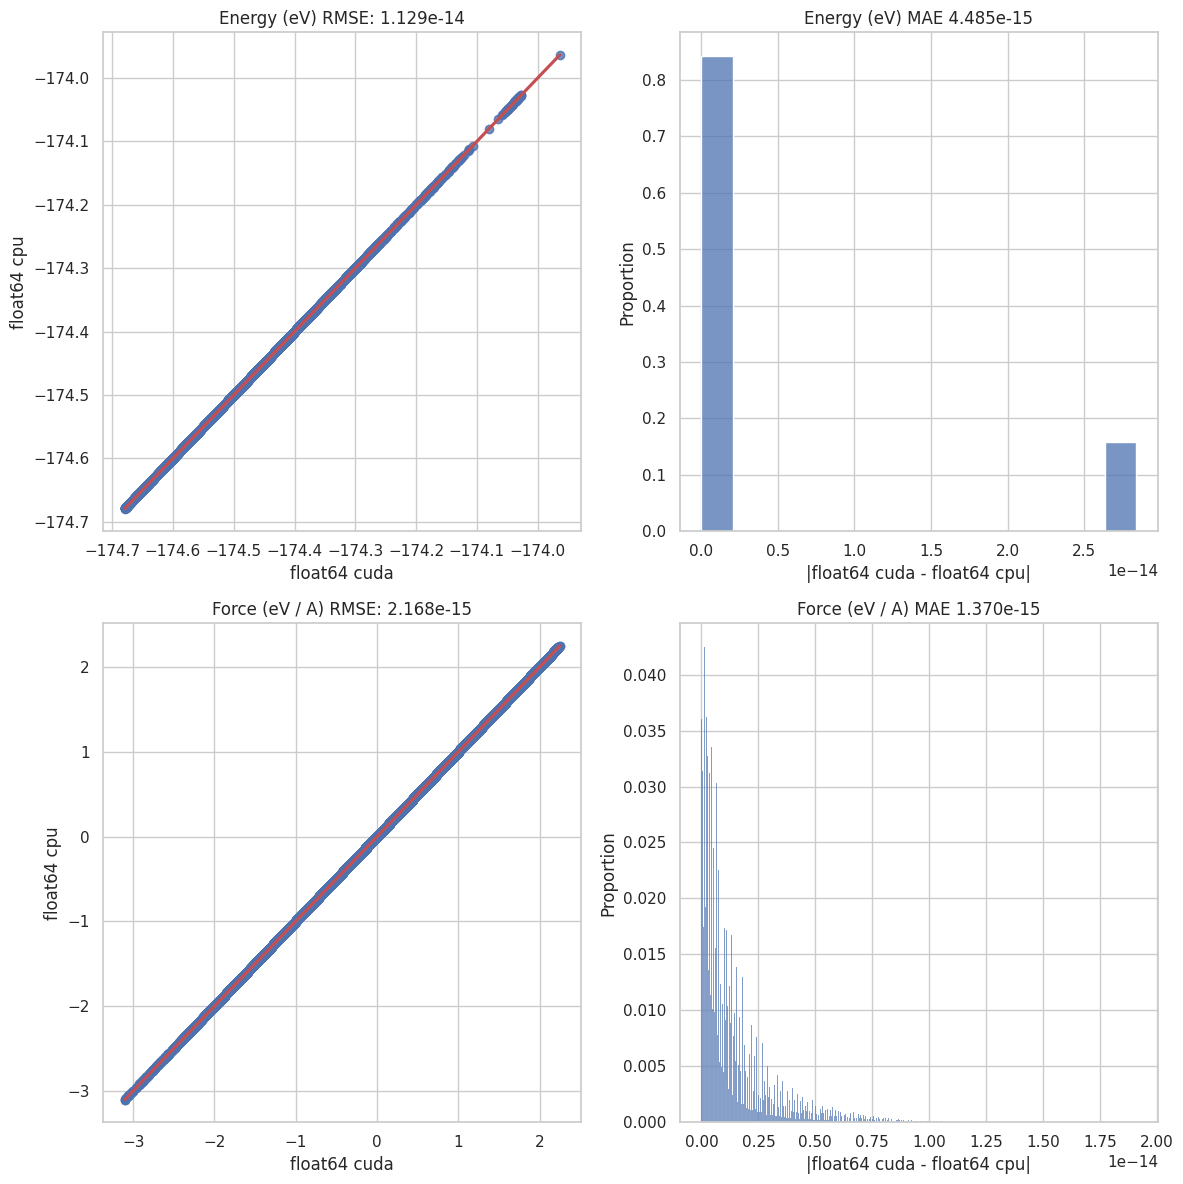

In [8]:
compare(fp64_cuda, fp64_cpu)

In [9]:
fp32_cpu = potential_energy(dataset, torch.float32, device="cpu")

Using local medium Materials Project MACE model for MACECalculator /home/ubuntu/macehh/mace/calculators/foundations_models/2023-12-03-mace-mp.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


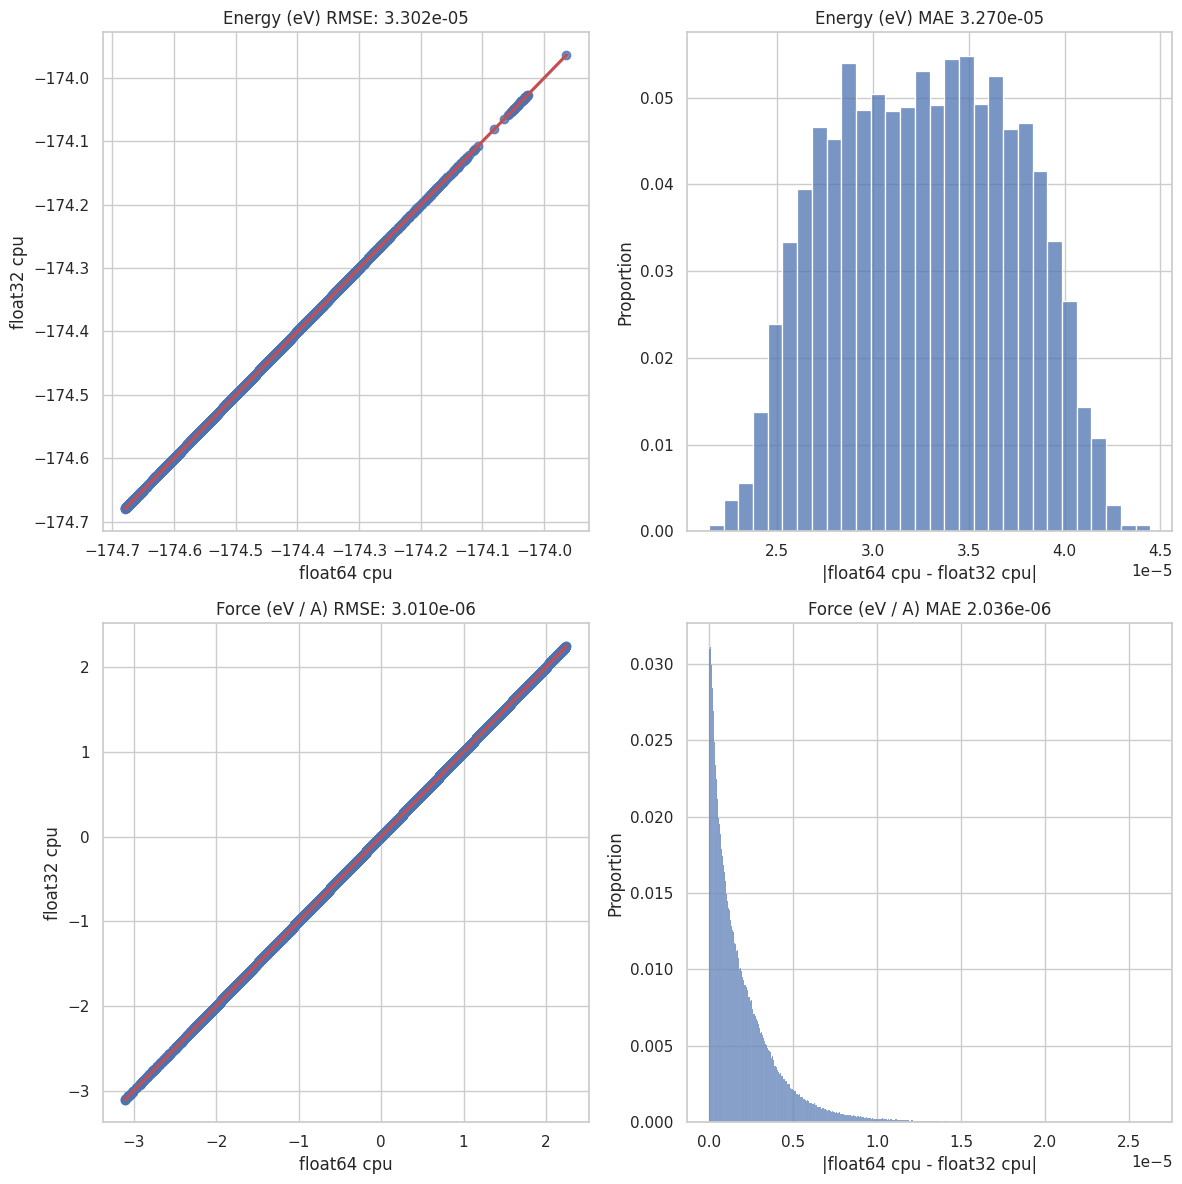

In [10]:
compare(fp64_cpu, fp32_cpu)

## MACE-MP0 Weights

The MACE MP weights are provided in float64

In [93]:
from mace.calculators.foundations_models import local_model_path

model = torch.load(local_model_path)
{param.dtype for param in model.parameters()}


{torch.float64}

Combine all the parameters into a single array to investigate statistical properties

In [94]:
w = []

for name, param in model.named_parameters():
    param = param.detach().numpy()
    param = param.reshape(-1)
    w.append(param)


w = np.concatenate(w)
w.shape

(4688656,)

There are no zero values in the parameters:

In [95]:
np.count_nonzero(w) == w.shape[0]

True

but there are many nearly zero values...

In [96]:
np.sum(np.abs(w) < 1e-15) / w.shape[0]

0.25901900246040654

(0.0, 1.0)

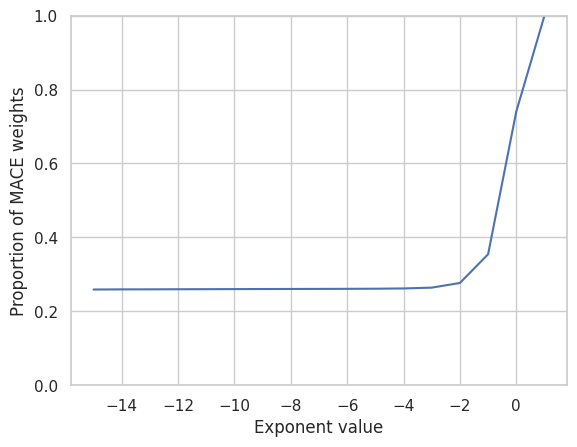

In [97]:
p = np.arange(-15, 2)
plt.plot(p, np.array([np.sum(np.abs(w) < 10.0**n) / w.shape[0] for n in p]))
plt.xlabel("Exponent value")
plt.ylabel("Proportion of MACE weights")
plt.ylim(0, 1)

<Axes: ylabel='Count'>

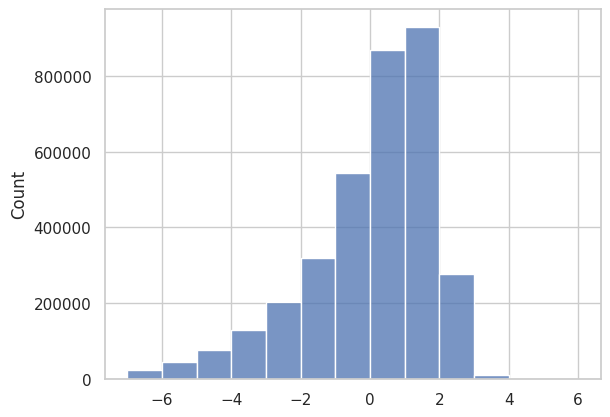

In [99]:
n = 7
sns.histplot(data=np.frexp(w)[1], bins=np.arange(-n, n))

Prepare a truncated version of these weights where we zero the tiny values.

In [100]:
threshold = 1e-7
state_dict = model.state_dict()

for k in state_dict.keys():
    v = state_dict[k]
    v[torch.abs(v) < threshold] = 0.0
    state_dict[k] = v

model.load_state_dict(state_dict)

<All keys matched successfully>

In [101]:
file = "/data/mace-mp0-truncated.model"
torch.save(model, file)

In [110]:
model = torch.load(file)
w = np.concatenate([p.detach().numpy().reshape(-1) for p in model.parameters()])
1 - np.count_nonzero(w) / w.shape[0]

0.26067043519507505

In [112]:
data = potential_energy(dataset, torch.float32, device="cuda", model=file)
data.label = "float32 cuda truncated"

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


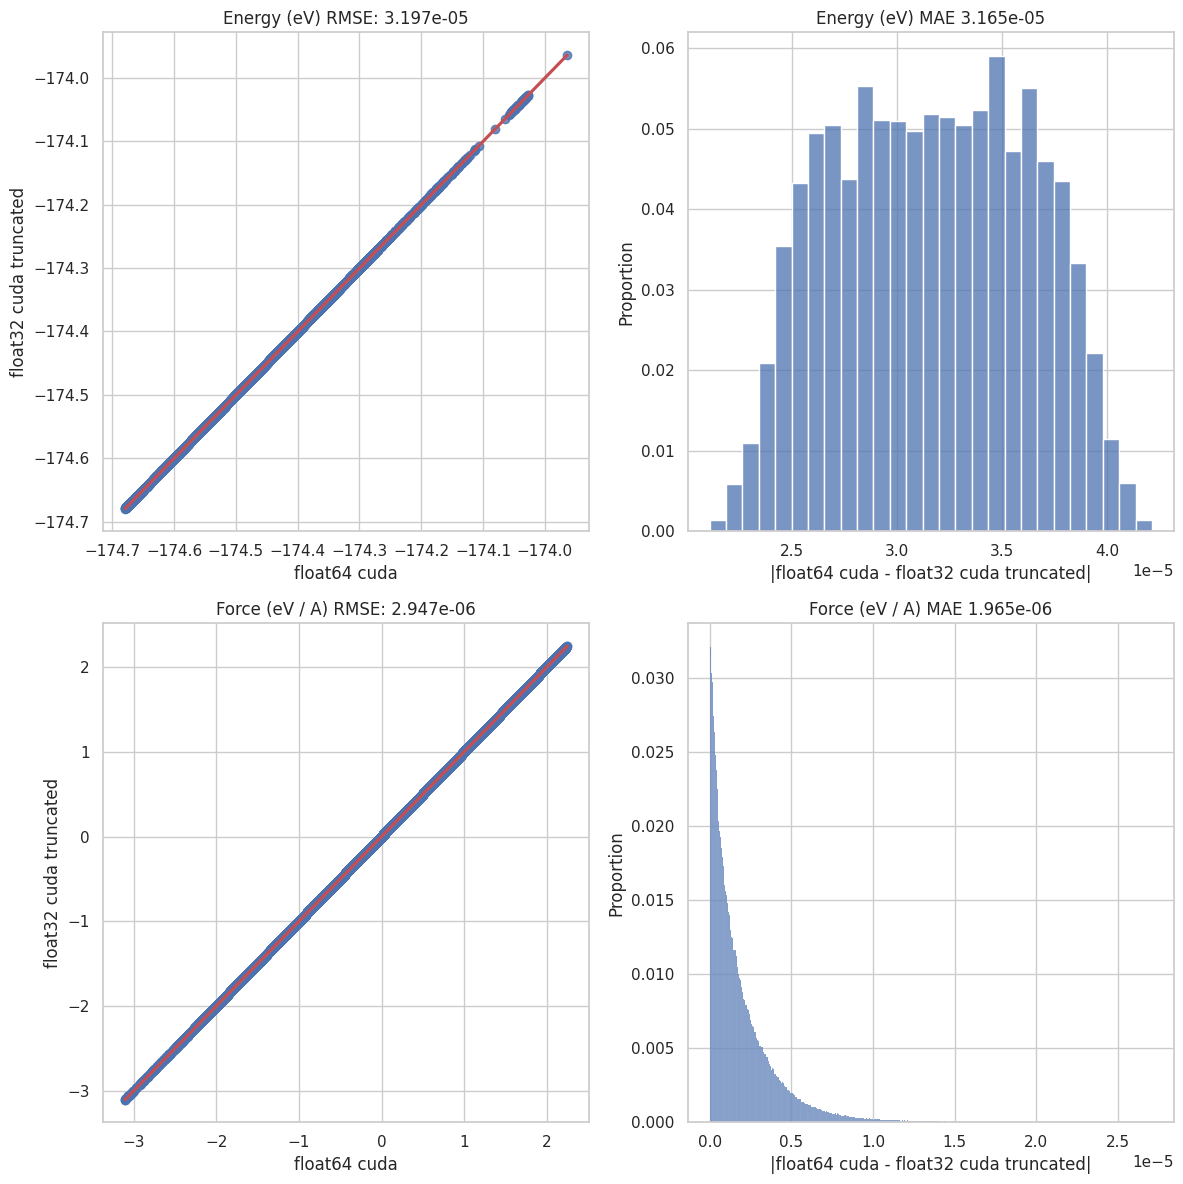

In [113]:
compare(fp64_cuda, data)

## Next Steps

* Compare training in float32 to float64
* Using automatic mixed precision for both inference and training
* the pre-trained weights appear as they may have some sparsity, can this be exploited with sparse tensor types?
